<a href="https://colab.research.google.com/github/PLEX-GR00T/Data_Mining/blob/main/TensorRT_Inference_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorRT Inference Comparison.

## pip installs and imports

In [1]:
!nvidia-smi
%cd /content

Wed May 25 03:54:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [4]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Hub version:  0.12.0
Eager mode:  True
GPU is available


In [5]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [6]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.0.0


#Data Loading

In [7]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!mkdir /content/drive/MyDrive/kaggle

mkdir: cannot create directory ‘/content/drive/MyDrive/kaggle’: File exists


In [9]:
!ls /content/drive/MyDrive/kaggle

kaggle.json


In [10]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [11]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


## Load the data

In [12]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
%ls

kaggle.json


In [14]:
!kaggle config set -n path -v /content

- path is now set to: /content


In [15]:
!kaggle config view #View current config values

Configuration values from /content/drive/MyDrive/kaggle
- username: gr00t16
- path: /content
- proxy: None
- competition: None


In [16]:
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


In [17]:
!unzip -qq gtsrb-german-traffic-sign.zip

replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [18]:
# !cp -R gtsrb-german-traffic-sign /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [19]:
#changing the working directory
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!pwd
!ls

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
gtsrb-german-traffic-sign.zip  Meta	 test  Test.csv  Train	    training_1
meta			       Meta.csv  Test  train	 Train.csv


In [20]:
%ls

gtsrb-german-traffic-sign.zip  Meta.csv  Test.csv  Train.csv
meta/                          test/     train/    training_1/
Meta/                          Test/     Train/


In [21]:
os.chdir('/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/')
%ls

gtsrb-german-traffic-sign.zip  Meta.csv  Test.csv  Train.csv
meta/                          test/     train/    training_1/
Meta/                          Test/     Train/


In [22]:
train_df = pd.read_csv('Train.csv')
# display a sneak peek of the data
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [23]:
print(f'Number of classes: {train_df.ClassId.unique().shape[0]}')

Number of classes: 43


In [24]:
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for trucks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for truck', 'No entry',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for truck']

In [25]:
# add column with readable labels
train_df['Label'] = train_df['ClassId'].replace(sorted(train_df['ClassId'].unique()), labels)
# print updated df
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Label
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Turn right
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Turn right
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Turn right
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Turn right
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Turn right


In [26]:
train_df.shape

(39209, 9)

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/test
/content


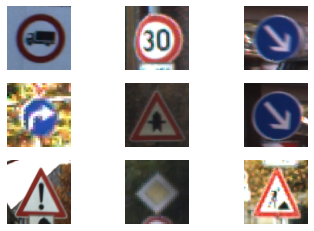

In [102]:
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/test

for i in range(9):
  img_path = './0000%d.png'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')

In [103]:
%cd /content/
plt.savefig('content.pdf')

/content


<Figure size 432x288 with 0 Axes>

## Model Building

In [27]:
base_dir = '/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Train'
print(base_dir)

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Train


In [28]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2) #Normalizing

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')#dividing image_size, batch_size

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [29]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape #each image is of size ??x??x??

((64, 224, 224, 3), (64, 43))

In [30]:
from time import time
#performing same process on the dataset
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
                   trainable=False),  
    tf.keras.layers.Dense(43, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23564800  
_________________________________________________________________
dense (Dense)                multiple                  88107     
Total params: 23,652,907
Trainable params: 88,107
Non-trainable params: 23,564,800
_________________________________________________________________


In [31]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [32]:
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
# Run model training
from time import time
#performing same process on the dataset
start_opt = time()
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(val_generator.samples/val_generator.batch_size)

checkpoint_path = "training_1/cp.ckpt" ##training saves weights that are done during training
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(
    train_generator, 
    epochs=17,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[cp_callback]).history
finish_opt = time()
f"Execution time with TensorFlow to train: {(finish_opt - start_opt):.2f} s"

Train for 491.0 steps, validate for 123.0 steps
Epoch 1/17
490/491 [============================>.] - ETA: 0s - loss: 0.7954 - acc: 0.7779
Epoch 00001: saving model to training_1/cp.ckpt
491/491 [==============================] - 139s 284ms/step - loss: 0.7943 - acc: 0.7782 - val_loss: 0.9214 - val_acc: 0.7136
Epoch 2/17
490/491 [============================>.] - ETA: 0s - loss: 0.2702 - acc: 0.9316
Epoch 00002: saving model to training_1/cp.ckpt
491/491 [==============================] - 128s 261ms/step - loss: 0.2700 - acc: 0.9317 - val_loss: 0.8886 - val_acc: 0.7323
Epoch 3/17
490/491 [============================>.] - ETA: 0s - loss: 0.1767 - acc: 0.9591
Epoch 00003: saving model to training_1/cp.ckpt
491/491 [==============================] - 126s 257ms/step - loss: 0.1768 - acc: 0.9591 - val_loss: 0.8659 - val_acc: 0.7463
Epoch 4/17
490/491 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9703
Epoch 00004: saving model to training_1/cp.ckpt
491/491 [============

'Execution time with TensorFlow to train: 2225.75 s'

In [35]:
prediction = time()
final_loss, final_accuracy = model.evaluate(val_generator, steps = val_steps_per_epoch)
predictend = time() - prediction
f"Inference time with TensorFlow : {(predictend):.2f} s"

123/123 [==============================] - 25s 206ms/step - loss: 1.0934 - acc: 0.7694


'Inference time with TensorFlow : 25.44 s'

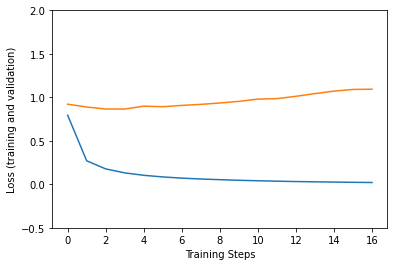

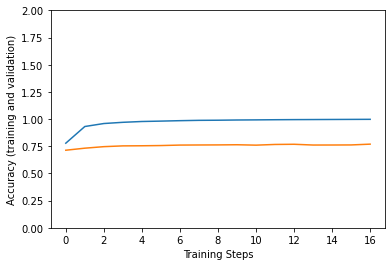

In [83]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([-0.5,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.savefig('resnet50.pdf')

In [37]:
model_TF2 = model

In [38]:
%cd /content/
model_TF2.save("model_TF2")

/content
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: model_TF2/assets


INFO:tensorflow:Assets written to: model_TF2/assets


In [39]:
inf_time_x_axis = [0, 0, 0, 0]
inf_acc_x_axis = [0, 0, 0, 0]
inf_throughput_x_axis = [0, 0, 0, 0]
x_labels = ['TF2.0', 'FP32', 'FP16', 'INT8']

# Install TensorFlow-GPU 2.0 and TensorRT Runtime

In [41]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.0.0


In [43]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

Selecting previously unselected package nvidia-machine-learning-repo-ubuntu1804.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:6 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.

--2022-05-25 04:34:19--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’

     0K ..                                                    100%  129M=0s

2022-05-25 04:34:19 (129 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and

In [44]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                    amd64        TensorRT runtime libraries


## Check Tensor core GPU

In [45]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: True


# Inference Comparisons

In [46]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.keras.preprocessing import image
from tensorflow.python.saved_model import tag_constants

## TF2.0 Inference: (model_TF2)

In [47]:
model = tf.keras.models.load_model("/content/model_TF2")

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/test
prediction shape:  (1, 43)
Predicted Image class: Only left
prediction shape:  (1, 43)
Predicted Image class: Only left
prediction shape:  (1, 43)
Predicted Image class: 60 km/h
prediction shape:  (1, 43)
Predicted Image class: Only left


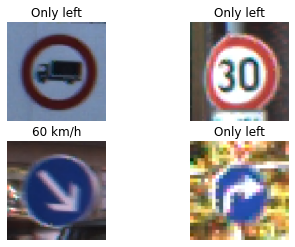

In [91]:
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/test
for i in range(4):
  img_path = './0000%d.png'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  preds = model.predict(x)
  print("prediction shape: ", preds.shape)
  classes = np.argmax(preds, axis = 1)
  print('Predicted Image class:', labels[int(classes)])
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(labels[int(classes)])

In [56]:
%cd /content
model_TF2.save("model_TF2")

/content
INFO:tensorflow:Assets written to: model_TF2/assets


INFO:tensorflow:Assets written to: model_TF2/assets


In [57]:
!saved_model_cli show --all --dir model_TF2


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 43)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [58]:
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/test

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/test


In [59]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './0000%d.png' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [60]:
# Benchmarking throughput
import time
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

st_fullbatch = time.time()

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

t_fullbatch = time.time() - st_fullbatch

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
print(f'Total Time: {t_fullbatch:.4f}s')

Step 0: 48.9ms
Step 50: 49.6ms
Step 100: 49.4ms
Step 150: 61.1ms
Step 200: 49.6ms
Step 250: 49.0ms
Step 300: 48.8ms
Step 350: 48.9ms
Step 400: 48.5ms
Step 450: 63.1ms
Step 500: 49.1ms
Step 550: 48.8ms
Step 600: 48.5ms
Step 650: 48.6ms
Step 700: 48.3ms
Step 750: 49.7ms
Step 800: 64.5ms
Step 850: 48.2ms
Step 900: 48.3ms
Step 950: 48.5ms
Throughput: 157 images/s
Total Time: 50.9996s


In [61]:
# inf_time_x_axis[0] = t_fullbatch
inf_time_x_axis[0] = 50.9996
inf_throughput_x_axis[0] = 157
print(inf_time_x_axis)
print(inf_throughput_x_axis)

[50.9996, 0, 0, 0]
[157, 0, 0, 0]


## Convert TF2.0 model to TF-TRT FP32 model

In [62]:
print('Converting TF2.0 model to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP32,
    max_workspace_size_bytes=8000000000
)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='/content/model_TF2',
    conversion_params=conversion_params
)

converter.convert()
converter.save(output_saved_model_dir='model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting TF2.0 model to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Assets written to: model_TFTRT_FP32/assets


INFO:tensorflow:Assets written to: model_TFTRT_FP32/assets


Done Converting to TF-TRT FP32


In [63]:
!saved_model_cli show --all --dir model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict


In [64]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []



    for i in range(N_warmup_run):
      labeling = infer(batched_input)
    
    st_fullbatch = time.time()

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    t_fullbatch = time.time() - st_fullbatch
    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
    print(f'Total time: {t_fullbatch:.4f}s')
    return t_fullbatch

In [65]:
t_fullbatch = benchmark_tftrt('model_TFTRT_FP32')

Step 0: 21.0ms
Step 50: 20.6ms
Step 100: 20.6ms
Step 150: 20.7ms
Step 200: 20.6ms
Step 250: 20.6ms
Step 300: 20.8ms
Step 350: 20.7ms
Step 400: 20.9ms
Step 450: 20.7ms
Step 500: 21.0ms
Step 550: 20.9ms
Step 600: 21.0ms
Step 650: 21.0ms
Step 700: 21.0ms
Step 750: 21.0ms
Step 800: 21.1ms
Step 850: 21.1ms
Step 900: 21.1ms
Step 950: 21.2ms
Throughput: 383 images/s
Total time: 20.9133s


In [66]:
# inf_time_x_axis[1] = t_fullbatch
inf_time_x_axis[1] = 20.9133
inf_throughput_x_axis[1] = 383
print(inf_time_x_axis)
print(inf_throughput_x_axis)

[50.9996, 20.9133, 0, 0]
[157, 383, 0, 0]


## Convert TF2.0 model to TF-TRT FP16 model

In [67]:
print('Converting TF2.0 model to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000
)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='/content/model_TF2',
    conversion_params=conversion_params
)

converter.convert()
converter.save(output_saved_model_dir='model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting TF2.0 model to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Assets written to: model_TFTRT_FP16/assets


INFO:tensorflow:Assets written to: model_TFTRT_FP16/assets


Done Converting to TF-TRT FP16


In [68]:
t_fullbatch = benchmark_tftrt('model_TFTRT_FP16')

Step 0: 21.0ms
Step 50: 20.7ms
Step 100: 20.6ms
Step 150: 20.2ms
Step 200: 20.6ms
Step 250: 20.6ms
Step 300: 20.5ms
Step 350: 20.7ms
Step 400: 20.6ms
Step 450: 20.7ms
Step 500: 20.9ms
Step 550: 20.7ms
Step 600: 20.9ms
Step 650: 20.9ms
Step 700: 20.8ms
Step 750: 21.0ms
Step 800: 21.1ms
Step 850: 21.0ms
Step 900: 21.1ms
Step 950: 21.2ms
Throughput: 385 images/s
Total time: 20.8273s


In [69]:
# inf_time_x_axis[2] = t_fullbatch
inf_time_x_axis[2] = 20.8273
inf_throughput_x_axis[2] = 385 
print(inf_time_x_axis)
print(inf_throughput_x_axis)

[50.9996, 20.9133, 20.8273, 0]
[157, 383, 385, 0]


## Convert TF2.0 model to TF-TRT INT8 model

In [ ]:
# Restart notebook runtime before proceeding?

In [70]:
print('Converting TF2.0 model to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8,
    max_workspace_size_bytes=8000000000,
    use_calibration=True
)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='/content/model_TF2',
    conversion_params=conversion_params
)

def calibration_input_fn():
    yield (batched_input, )

converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting TF2.0 model to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Assets written to: model_TFTRT_INT8/assets


INFO:tensorflow:Assets written to: model_TFTRT_INT8/assets


Done Converting to TF-TRT INT8


In [71]:
t_fullbatch = benchmark_tftrt('model_TFTRT_INT8')

Step 0:  5.5ms
Step 50:  5.5ms
Step 100:  5.5ms
Step 150:  5.6ms
Step 200:  5.7ms
Step 250:  5.5ms
Step 300:  5.5ms
Step 350:  5.7ms
Step 400:  5.6ms
Step 450:  5.5ms
Step 500:  5.6ms
Step 550:  5.6ms
Step 600:  5.6ms
Step 650:  5.6ms
Step 700:  5.6ms
Step 750:  5.6ms
Step 800:  5.6ms
Step 850:  5.6ms
Step 900:  5.7ms
Step 950:  5.6ms
Throughput: 1431 images/s
Total time: 5.6181s


In [72]:
# inf_time_x_axis[3] = t_fullbatch
inf_time_x_axis[3] = 5.6181
inf_throughput_x_axis[3] = 1431
print(inf_time_x_axis)
print(inf_throughput_x_axis)

[50.9996, 20.9133, 20.8273, 5.6181]
[157, 383, 385, 1431]


# Inference Comparision Results (1000 images)

In [73]:
x_labels = ['TF2.0', 'FP32', 'FP16', 'INT8']

In [74]:
%cd /content/

/content


## Time

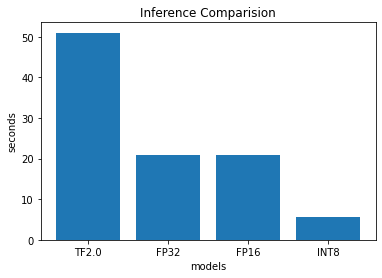

In [75]:
import matplotlib.pyplot as plt
plt.bar(x_labels, inf_time_x_axis)
plt.ylabel('seconds')
plt.xlabel('models')
plt.title('Inference Comparision')
plt.savefig('outputneural_1.pdf')
plt.show()

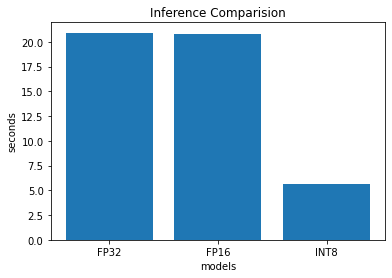

In [76]:
plt.bar(x_labels[1:], inf_time_x_axis[1:])
plt.ylabel('seconds')
plt.xlabel('models')
plt.title('Inference Comparision')
plt.savefig('outputneural_2.pdf')
plt.show()

## Throughput

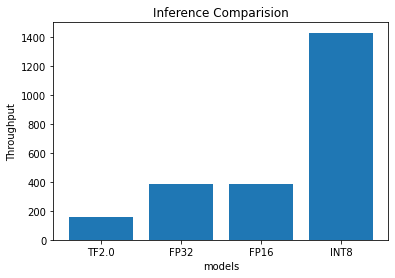

In [77]:
import matplotlib.pyplot as plt
plt.bar(x_labels, inf_throughput_x_axis)
plt.ylabel('Throughput')
plt.xlabel('models')
plt.title('Inference Comparision')
plt.savefig('throughput_1.pdf')
plt.show()

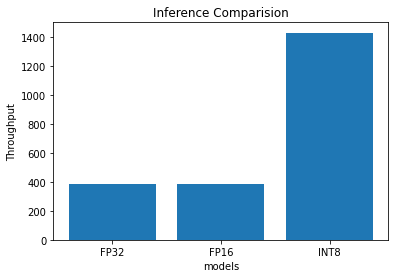

In [79]:
plt.bar(x_labels[1:], inf_throughput_x_axis[1:])
plt.ylabel('Throughput')
plt.xlabel('models')
plt.title('Inference Comparision')
plt.savefig('throughput_2.pdf')
plt.show()

### Thank you...!!!

For all model comparisons and their Tables please read the provided report.